In [79]:
import pandas as pd
from pandas_summary import DataFrameSummary
import numpy as np
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection.partial_dependence import partial_dependence, plot_partial_dependence
from treeinterpreter import treeinterpreter as ti
import lime
import lime.lime_tabular
from lime import submodular_pick
import matplotlib.pyplot as plt
import shap
shap.initjs()
import seaborn as sns
sns.set()

In [80]:
from pycebox.ice import ice, ice_plot

ModuleNotFoundError: No module named 'pycebox'

In [2]:
pd.options.display.float_format = '{:.1f}'.format

# Last inn data
<img src="https://cdn.pixabay.com/photo/2017/11/29/14/54/melbourne-2986345_960_720.jpg" width="300" height="300" align="left"/>

Dette datasettet er et fritt tilgjengelig datasett fra vanlig boligsalg i Melbourne i Australia. Datasettet er hentet fra data-science platformen Kaggle, og finnes tilgjengelig [her](https://www.kaggle.com/anthonypino/melbourne-housing-market)



In [3]:
datapath = "MELBOURNE_HOUSE_PRICES_LESS.csv"
df = pd.read_csv(datapath, parse_dates=["Date"])

In [4]:
df.shape

(63023, 13)

Noen hus i datasettet mangler en salgspris. Vi velger å fjerne disse husene

In [5]:
df = df.dropna(subset=["Price"])

In [6]:
df.shape

(48433, 13)

# Oppsummering av data
Suburb: Suburb

Address: Address

Rooms: Number of rooms

Price: Price in Australian dollars

Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

SellerG: Real Estate Agent

Date: Date sold

Distance: Distance from CBD in Kilometres

Regionname: General Region (West, North West, North, North east ...etc)

Propertycount: Number of properties that exist in the suburb.

Bedroom2 : Scraped # of Bedrooms (from different source)

Bathroom: Number of Bathrooms

Car: Number of carspots

Landsize: Land Size in Metres

BuildingArea: Building Size in Metres

YearBuilt: Year the house was built

CouncilArea: Governing council for the area

Lattitude: Self explanitory

Longtitude: Self explanitory

In [7]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,Jellis,2017-01-04,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,Abbotsford,59A Turner St,3,h,1220000.0,S,Marshall,2017-01-04,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,Nelson,2017-01-04,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,Barry,2017-01-04,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,Nelson,2017-01-04,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council


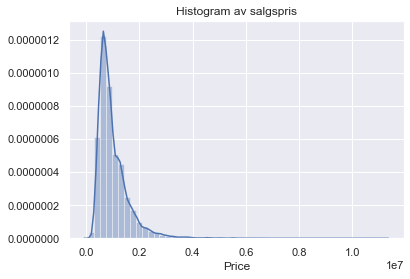

In [8]:
sns.distplot(df["Price"]);
plt.title("Histogram av salgspris");

In [9]:
summ = DataFrameSummary(df).summary().T
summ.sort_values(by=["types", "count", "uniques"])

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48433,3,0,0%,categorical
Method,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48433,5,0,0%,categorical
Regionname,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48433,8,0,0%,categorical
CouncilArea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48433,34,0,0%,categorical
Suburb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48433,370,0,0%,categorical
SellerG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48433,422,0,0%,categorical
Address,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48433,44739,0,0%,categorical
Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48433,112,0,0%,date
Rooms,48433.0,3.1,0.9,1.0,2.0,3.0,4.0,31.0,48433,14,0,0%,numeric
Distance,48433.0,12.7,7.6,0.0,7.0,11.7,16.7,55.8,48433,176,0,0%,numeric


Ut ifra statistikken, kan vi observere blant annet:
- Mange av featurene er kategoriske, enkelte med høy kardinalitet
- Postcode har tallverdi, men er mest sannsynlig kategorisk
- 23% av radene mangler pris

# EDA
Ved å se på korrelasjonsmatrisen til dataen, kan vi se om det finnes noen åpenbare sammenhenger mellom salgspris og noen av de andre featurene

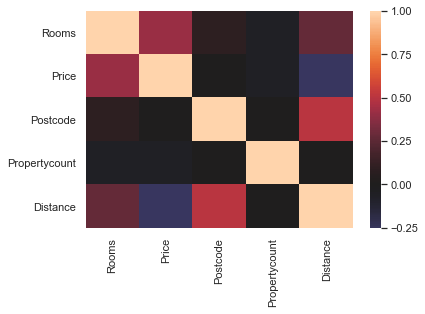

In [10]:
sns.heatmap(df.corr(), center=0);

### Inspeksjon av korrelerte features

På figurene nedenfor er det vist det parvise forholdet mellom feature og target-verdi. En regresjonslinje er tilpasset hvert enkelt plot.

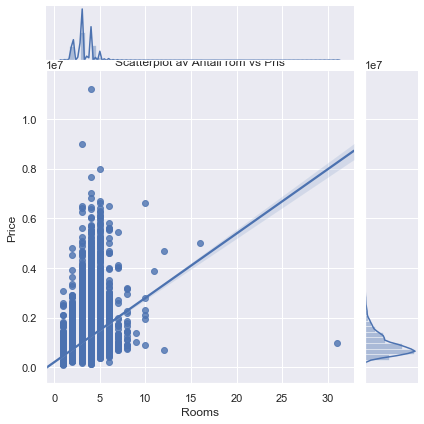

In [11]:
g = sns.JointGrid(x="Rooms", y="Price", data=df)
g = g.plot(sns.regplot, sns.distplot)
plt.title("Scatterplot av Antall rom vs Pris");

Vi kan observere at pris har positiv korrelasjon med antall rom i boligen.

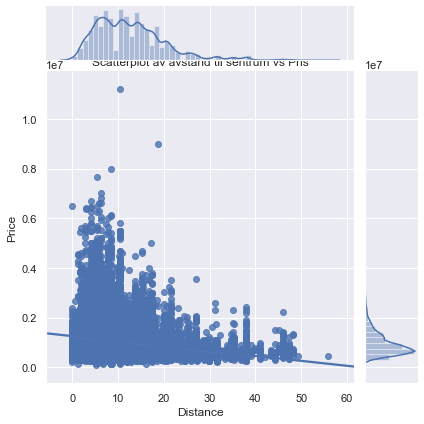

In [12]:
g = sns.JointGrid(x="Distance", y="Price", data=df)
g = g.plot(sns.regplot, sns.distplot)
plt.title("Scatterplot av avstand til sentrum vs Pris");

Vi kan observere at avstand til sentrum korrelerer negativt med pris

# Feature engineering

In [13]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Postcode', 'Regionname', 'Propertycount', 'Distance',
       'CouncilArea'],
      dtype='object')

## Fiks datatyper

In [14]:
categorical_feature_names = ["Suburb", "Type", "Method", "Regionname", "CouncilArea"]
df[categorical_feature_names] = df[categorical_feature_names].astype("category")

### Spesifiser kolonner som ikke skal brukes
- Address har meget høy kardinalitet, og vil mest sannsynlig ikke inneholde signaler
- Vi har allerede hentet ut år og måned fra datokolonnen. Modellene vi bruker klarer ikke bruke datetime kolonner
- Vi vil fjerne target-variablen (Price) fra treningssettet
- Vi ønsker å se bort ifra hvilken selger som har solgt huset

In [15]:
columns_to_drop = ["Address", "Date", "Price", "SellerG"]

## Gjør om dato til år og måned

In [16]:
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year

In [17]:
df.dtypes

Suburb                 category
Address                  object
Rooms                     int64
Type                   category
Price                   float64
Method                 category
SellerG                  object
Date             datetime64[ns]
Postcode                  int64
Regionname             category
Propertycount             int64
Distance                float64
CouncilArea            category
Month                     int64
Year                      int64
dtype: object

# Evalueringskriterier og Metrikker
For å evaluere modellytelse for en regresjonsmodell har vi valgt å benytte metrikkene
Forklaring av variabler:
- $y$ er den faktiske salgsprisen av boligen
- $\hat{y}$ er den predikerte salgsprisen fra modellen
- $\bar{y}$ er gjennomsnitsverdien av salgsprisen
- $ln$ betegner den naturlige logaritmen

## Winsorized Absolute Log Error (WALE)
WALE er en nyttig metrikk i tilfeller der store outliers i datasettet vil føre til at andre metrikker vil domineres av disse.
WALE er definert på følgende måte:

\begin{align}
WALE = \frac{1}{N}\sum_{i=1}^{N}min(|ln(\hat{y}_i) - ln(y_i)|, 0.4)
\end{align}

**Tolkning: Jo lavere tall, jo bedre.**

WALE har etter vår kunnskap ingen implementasjon i noen open-source bibliotek, og er definert nedenfor

In [18]:
def winsorized_absolute_log_error(y_true, y_pred, epsilon=1e-7):
    return np.mean(np.minimum(np.abs(np.log(y_pred+epsilon) - np.log(y_true+epsilon)), 0.4))

## Root Mean Squared Error (RMSE)
RMSE er en metrikk vil "straffe" prediksjoner som bommer stort
\begin{align}
RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(\hat{y}_i - y_i)^2}
\end{align}

**Tolkning: Jo lavere tall, jo bedre.**

## Mean Absolute Error (MAE)
Fordelen med MAE, er at man intuitivt kan forholde seg til verdien, som sier hvor mye modellen i gjennomsnitt bommer på faktisk salgspris.
\begin{align}
MAE = \frac{1}{N}\sum_{i=1}^{N}|\hat{y}_i - y_i|
\end{align}

**Tolkning: Samme enheter som målvariablen (Salgspris i Australske Dollar). Jo lavere tall, jo bedre.**

## $R^2$-score / Coefficient of determination
$R^2$ beskriver andelen varians som forklares av de uavhengige variablene i modellen. Metrikken gir oss en indikasjon på "goodness of fit", og dermed et mål på hvor godt modellen klarer å predikere usett data riktig.

\begin{align}
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
\end{align}

**Tolkning: Tar verdien 0-1, der 0 betyr at modellen gjør det like godt som å alltid predikere gjennomsnittet, mens 1 betyr at modellens prediksjoner passer perfekt til dataen.**

Rammeverket scikit-learn har gode implementasjoner av disse metrikkene, som vil brukes i denne notebooken

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Vi definerer også en funksjon for å regne ut alle metrikkene

In [20]:
def get_metrics(true, pred, print_metrics=True):
    WALE = winsorized_absolute_log_error(true, pred)
    RMSE = np.sqrt(mean_squared_error(true, pred))
    MAE = mean_absolute_error(true, pred)
    R2 = r2_score(true, pred)
    return_dict = {"WALE": WALE, "RMSE": RMSE, "MAE": MAE, "R2": R2}
    if print_metrics:
        for k,v in return_dict.items():
            print(f"{k}: {v}")
    return return_dict

# Oppdeling av trening, validering og holdout-test-sett
Vi velger å bruke 80% av dataen til modellering/trening, 10% av dataen brukes til å validere modellen, mens 10% brukes som holdout-test-set for å evaluere modellen. Måten vi deler opp dette er på tid, der vi bruker den eldste dataen til å modellere, mens nyeste data brukes til å validere og evaluere

In [21]:
df = df.sort_values(by="Date")
holdout_test_idx = df.shape[0] - int(df.shape[0] * 0.1)
val_idx = df.shape[0] - int(df.shape[0] * 0.1) * 2

In [22]:
def split_dataset(dataframe, val_index, holdout_test_index):
    train = dataframe.iloc[:val_index]
    val = dataframe.iloc[val_index:holdout_test_index]
    holdout_test = dataframe.iloc[holdout_test_index:]
    return train, val, holdout_test

# Prediksjon av salgspris

## Baseline-modell
Vi setter opp en baseline-modell, som alltid bør bli "slått" av en modell vi lager:
- En modell som alltid predikerer gjennomsnittet av salgsprisen

In [23]:
from sklearn.dummy import DummyRegressor

In [24]:
dummy_train, dummy_val, dummy_test = split_dataset(df, val_idx, holdout_test_idx)

In [25]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(dummy_train, dummy_train["Price"])

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [26]:
dummy_pred = dummy.predict(dummy_test)

### Metrikker for dummy-regressor

In [27]:
dummy_metrics = get_metrics(dummy_test["Price"], dummy_pred)

WALE: 0.29025729275344037
RMSE: 538572.2569670953
MAE: 392921.0129480561
R2: -0.002604461642750966


## Fremgangsmåte 1: Lineær regresjon, med one-hot encoding av kategoriske variabler
En lineær-regresjonsmodell forsøker å finne de koeffisientene til input-featurene som minimerer summen av kvadratisk feil (Sum of squared errors).

\begin{align}
\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_N x_N
\end{align}

der $\beta_0$ er intercept, $\beta_1-\beta_N$ er de lærte koeffisientene til featurene, og $x_1-x_N$ er verdien til featurene

### Preprossesering
For å kunne bruke kategoriske variabler i en lineær regresjon må man bruke one-hot-encoding eller tilsvarende

#### One-hot-encoding

In [28]:
dummies = pd.get_dummies(df[categorical_feature_names])
non_dummies = df.drop(columns=categorical_feature_names)
lr_df = non_dummies.join(dummies)

#### Inndeling i trening, validering og test

In [29]:
lr_train, lr_val, lr_holdout_test = split_dataset(lr_df, val_idx, holdout_test_idx)
lr_X_train = lr_train.drop(columns=columns_to_drop)
lr_y_train = lr_train["Price"]

lr_X_val = lr_val.drop(columns=columns_to_drop)
lr_y_val = lr_val["Price"]

lr_X_test = lr_holdout_test.drop(columns=columns_to_drop)
lr_y_test = lr_holdout_test["Price"]

In [30]:
lr_X_train.shape

(38747, 426)

Vi ender altså opp med et datasett som inneholder 646 features

### Modellering
Først trener vi en lineær regresjonsmodell

In [31]:
linreg = LinearRegression()
linreg.fit(lr_X_train, lr_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Vi kan så undersøke intercept og koeffisientene til linreg-modellen

In [32]:
linreg.intercept_

154332802526121.7

In [33]:
# 10 første koeffisienter
linreg.coef_[:10]

array([ 2.38257226e+05, -1.37447691e+09,  1.00517491e+08, -4.85059033e+11,
        6.84248738e+03,  8.32347937e+04,  4.31568296e+11, -7.74399122e+11,
        4.41926418e+11,  8.35216711e+11])

### Evaluering
Så bruker vi modellen til å predikere test-settet vårt. I tabellen nedenfor kan vi se faktisk verdi (true) samt predikert verdi(pred) og absoluttverdien av differansen mellom faktisk og predikert verdi

In [34]:
lr_pred = linreg.predict(lr_X_test.values)
lr_res = pd.DataFrame({'true': lr_y_test, 'pred': lr_pred})
lr_res["diff"] = lr_res["true"] - lr_res["pred"]
lr_res["absDiff"] = (lr_res["true"] - lr_res["pred"]).abs()
lr_res.sort_values(by="absDiff", inplace=True)

#### Fem tilfeller der modellen treffer best

In [35]:
lr_res.head()

,true,pred,diff,absDiff
58359,1000000.0,999968.3,31.7,31.7
27718,1170000.0,1170045.6,-45.6,45.6
27827,2000000.0,2000194.0,-194.0,194.0
13273,1255000.0,1254682.5,317.5,317.5
58093,1625000.0,1625370.3,-370.3,370.3


#### Fem tilfeller der modellen treffer dårligst

In [36]:
lr_res.tail()

,true,pred,diff,absDiff
51350,930500.0,-1500241780416.1,1500242710916.1,1500242710916.1
36531,545000.0,-1500242257499.1,1500242802499.1,1500242802499.1
40958,679000.0,-1500242264341.6,1500242943341.6,1500242943341.6
20605,397000.0,-1646820913568.8,1646821310568.8,1646821310568.8
40876,441000.0,2031453412618.3,-2031452971618.3,2031452971618.3


#### Fordeling av prediksjoner

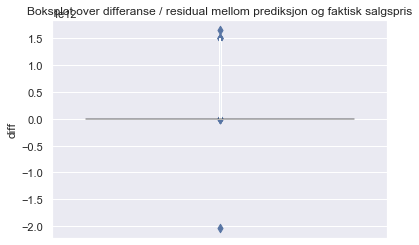

In [37]:
sns.boxenplot("diff", data=lr_res, orient="v").set_title("Boksplot over differanse / residual mellom prediksjon og faktisk salgspris");

I plottet under kan vi se sammenhengen mellom predikert verdi og faktisk verdi. Helst ville vi sett en diagonal linje

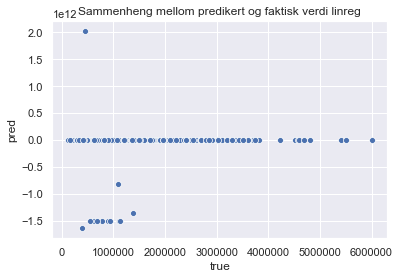

In [38]:
sns.scatterplot("true", "pred", data=lr_res);
plt.title("Sammenheng mellom predikert og faktisk verdi linreg");

#### Klipping av negative verdier
For at metrikkene som er valgt skal gi mening, klipper vi alle verdiene som er negative, til å være 0

In [39]:
lr_pred = np.clip(lr_pred, a_min=0, a_max=None)

### Metrikker på testdata

In [40]:
lr_metrics = get_metrics(lr_y_test, lr_pred)

WALE: 0.21365336924482753
RMSE: 29191038002.396107
MAE: 419701892.0218098
R2: -2945376063.06564


### Metrikker på treningsdata
Hvis vi sammenligner metrikkene evaluert på testsettet med metrikkene evaluert på treningssettet, kan vi undersøke hvor godt modellen klarer å predikere nye data

In [41]:
lr_train_pred = linreg.predict(lr_X_train)
lr_train_pred = np.clip(lr_train_pred, a_min=0, a_max=None)
lr_train_metrics = get_metrics(lr_y_train, lr_train_pred)

WALE: 0.19495406073996915
RMSE: 358488.7627689103
MAE: 221611.4745335123
R2: 0.6479298707431886


Vi ser at metrikkene evaluert på treningssettet gir oss et mye bedre resultat

### Konklusjon fremgangsmåte 1: Lineær regresjon, med one-hot encoding av kategoriske variabler
Vi ser at med en "naiv" lineær regresjonsmodell som bruker alle featurene, klarer vi ikke å generalisere
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Fremgangsmåte 2: Random forest for feature selection for lineær regresjon

### Preprossesering
Før dataen kan mates inn i modellen, må gjøre om kategoriske variabler representert som strenger om til heltall

In [42]:
columns_to_encode = ["Suburb", "Type", "Method", "Regionname", "CouncilArea"]
rfs_enc = OrdinalEncoder()
rfs_df = df.copy()
rfs_df[columns_to_encode] = rfs_enc.fit_transform(df[columns_to_encode])
rfs_df[columns_to_encode] = rfs_df[columns_to_encode].astype(int)

### Oppdeling i trening, validering og holdout-testsett

In [43]:
rfs_train, rfs_valid, rfs_holdout_test = split_dataset(rfs_df, val_idx, holdout_test_idx)
rfs_X_train = rfs_train.drop(columns=columns_to_drop)
rfs_y_train = rfs_train["Price"]

rfs_X_test = rfs_holdout_test.drop(columns=columns_to_drop)
rfs_y_test = rfs_holdout_test["Price"]

### Modellering
Vi bruker sklearn-implementasjonen av Random Forest for å trene opp en modell

In [44]:
rfs = RandomForestRegressor(n_estimators=100)
rfs.fit(rfs_X_train, rfs_y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

### Evaluering

In [45]:
rfs_pred = rfs.predict(rfs_X_test)
rfs_res = pd.DataFrame({"true": rfs_y_test, "pred": rfs_pred})
rfs_res["absDiff"] = (rfs_res["true"] - rfs_res["pred"]).abs()
rfs_res.sort_values(by="absDiff", inplace=True)

#### De fem tilfellene der modellen predikerer nærmest faktisk salgspris

In [46]:
rfs_res.head()

,true,pred,absDiff
36594,390000.0,389989.2,10.8
44357,460000.0,459937.2,62.8
13562,780000.0,780193.3,193.3
27922,620000.0,619791.2,208.8
58330,442500.0,442242.5,257.5


#### De fem tilfellene der modellen predikerer lengst unna faktisk salgspris

In [47]:
rfs_res.tail()

,true,pred,absDiff
58231,850000.0,3743867.5,2893867.5
44264,5500000.0,2555583.3,2944416.7
13688,867000.0,3858090.7,2991090.7
27820,2325000.0,5327260.0,3002260.0
24818,2890000.0,7066069.7,4176069.7


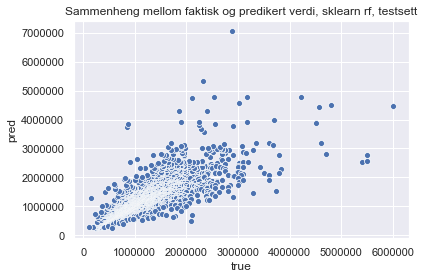

In [48]:
sns.scatterplot("true", "pred", data=rfs_res);
plt.title("Sammenheng mellom faktisk og predikert verdi, sklearn rf, testsett");

### Metrikker for Random forest-modell

In [49]:
rf_metrics = get_metrics(rfs_y_test, rfs_pred)

WALE: 0.16343754505769434
RMSE: 322975.0411691663
MAE: 192624.17455427055
R2: 0.6394382930695652


### Feature importance
De fleste Random Forest-implementasjonene har muligheter for å hente ut en såkalt "feature importance", som kort forklart forteller hvor "viktig" hver uavhengige variabel / feature var for resultatet  

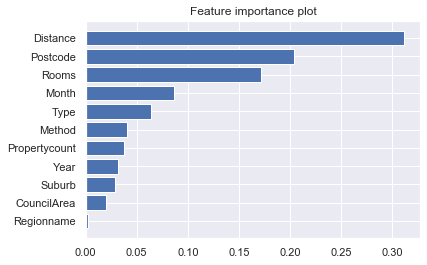

In [50]:
rfs_fi = list(zip(rfs_X_test.columns, rfs.feature_importances_))
rfs_fi.sort(key=lambda x: x[1])
rfs_name, rfs_feature_importance = zip(*rfs_fi)
plt.barh(rfs_name, rfs_feature_importance);
plt.title("Feature importance plot");

Vi kan i feature importance-plottet over se at det er spesiellt tre features som er viktige med tanke på prediksjonen:
- Avstand til sentrum (Distance)
- Postcode (Postnummer)
- Antall rom (Rooms)

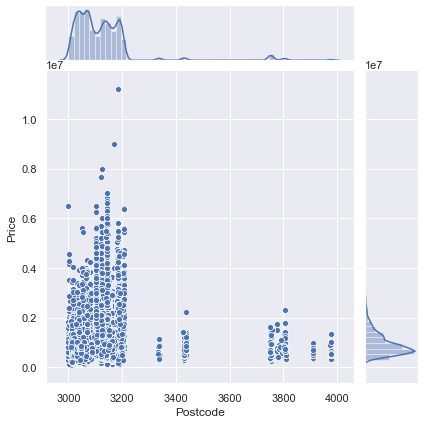

In [51]:
g = sns.JointGrid(x="Postcode", y="Price", data=df)
g = g.plot(sns.scatterplot, sns.distplot)

### Partial Dependance Plots (PDP)
Plot av denne types viser avhengigheten mellom målvariablen (salgspris) og et sett med target features, samtidig som den marginaliserer over alle andre features. Figurene under viser PDP-plot for de tre featurene som ble ansett som viktigst fra feature importance

<Figure size 1440x720 with 0 Axes>

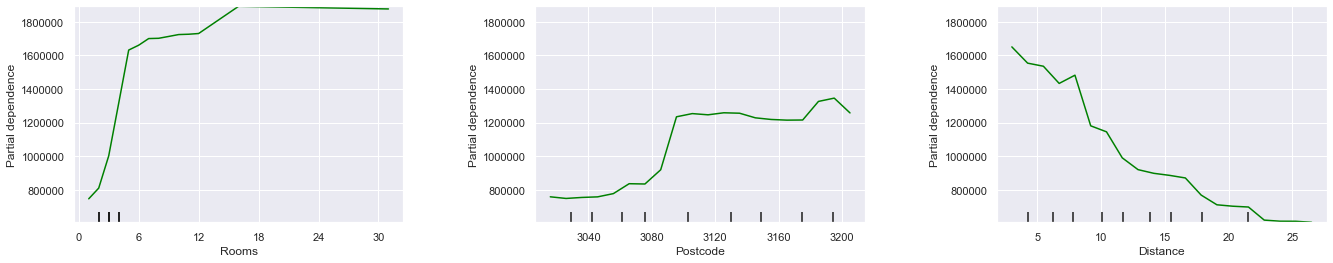

In [52]:
plt.figure(figsize=(20, 10))
plot_partial_dependence(rfs, rfs_X_train, features=[1,4,7], feature_names=rfs_X_test.columns.tolist(), grid_resolution=20)
fig = plt.gcf()
plt.subplots_adjust(top=0.9, right=3)

### Transformasjon av features for lineær regresjon

In [53]:
transformed_linreg_columns = ["Price", "Rooms", "Postcode", "Distance"]

lrt_df = df[transformed_linreg_columns].copy()

#### Separer boliger der rom > 6 i egen kategori
Det ser ut som salgspris stiger relativt lineært sammen med antall rom mens antall rom er opp til 6. Med flere rom enn dette stiger ikke prisen like mye, og flater ut ved ca 16 rom.

Vi kan sette alle boliger som har lik eller flere rom enn 6 til å være konstant

In [54]:
lrt_df.loc[lrt_df["Rooms"] >= 6, "Rooms"] = 6

#### Grupper Postcode i to kategorier
Det kan virke som hus med postnummer under 3100 har en betydelig lavere salgspris enn hus med postnummer høyere eller lik 3100. Vi kan dele de inn i to grupper, over eller under postnummer 3100

In [55]:
lrt_df["Postcode_ge_3100"] = 1
lrt_df.loc[lrt_df["Postcode"] < 3100, "Postcode_ge_3100"] = 0

#### Observasjoner i distance
Vi ser at distanse til sentrum (Distance) er tilnærmet lineær med salgspris, med negativ koeffisient. Vi velger å ikke utføre noen transformasjoner med denne, og lar den være som den er

### Lineær regresjon med transformerte features
Med våre nye, og forhåpentligvis forbedrede features forsøker vi nå å lage en ny linreg-modell

In [56]:
lrt_features = ["Rooms", "Postcode_ge_3100", "Distance"]

In [57]:
lrt_train, lrt_val, lrt_holdout_test = split_dataset(lrt_df, val_idx, holdout_test_idx)
lrt_X_train = lrt_train[lrt_features]
lrt_y_train = lrt_train["Price"]

lrt_X_val = lrt_val[lrt_features]
lrt_y_val = lrt_val["Price"]

lrt_X_test = lrt_holdout_test[lrt_features]
lrt_y_test = lrt_holdout_test["Price"]

In [58]:
linreg_t = LinearRegression()
linreg_t.fit(lrt_X_train, lrt_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [59]:
lrt_pred = linreg_t.predict(lrt_X_test)
lrt_res = pd.DataFrame({"true": lrt_y_test, "pred": lrt_pred})
lrt_res["absDiff"] = (lrt_res["true"] - lrt_res["pred"]).abs()
lrt_res.sort_values(by="absDiff", inplace=True)

lrt_pred = np.clip(lrt_pred, 0, None)

### Metrikker for lineær regresjon med feature-transformasjon

In [60]:
lrt_metrics = get_metrics(lrt_y_test, lrt_pred)

WALE: 0.23104866087402517
RMSE: 390893.60035995353
MAE: 270225.5694017852
R2: 0.47184816002503205


### Sammenheng mellom prediksjoner og faktisk salgspris

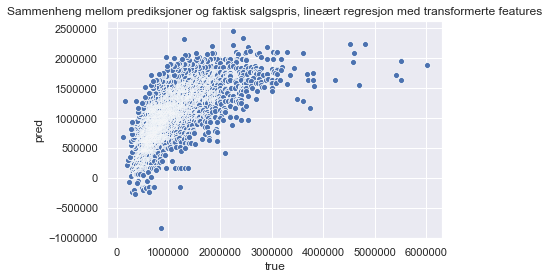

In [61]:
sns.scatterplot("true", "pred", data=lrt_res);
plt.title("Sammenheng mellom prediksjoner og faktisk salgspris, lineært regresjon med transformerte features");

### Sammenligning av lineær regresjon før og etter feature-transformasjoner

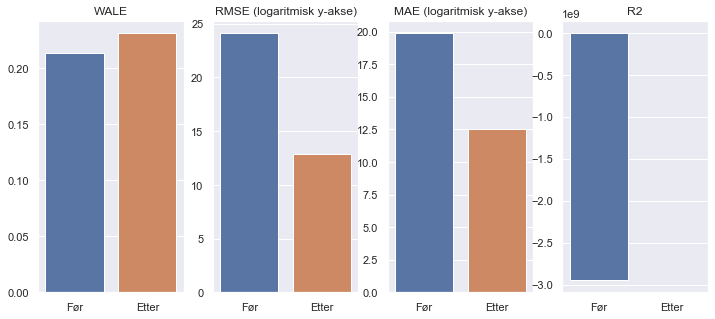

In [62]:
fig, axs = plt.subplots(1,4,figsize=(12,5))
xnames = ["Før", "Etter"]
for idx, (before_trans, after_trans) in enumerate(zip(lr_metrics.items(), lrt_metrics.items())):
    if  0 < idx < 3:
        sns.barplot(x=xnames, y=[np.log(before_trans[1]), np.log(after_trans[1])], ax=axs[idx]).set_title(f"{before_trans[0]} (logaritmisk y-akse)")
    else:
        sns.barplot(x=xnames, y=[before_trans[1], after_trans[1]], ax=axs[idx]).set_title(f"{before_trans[0]}")
    

Antall features opprinnelig modell: 426
Antall features modifisert modell: 3


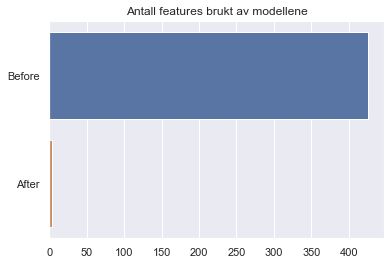

In [63]:
sns.barplot(y=["Before", "After"], x=[linreg.coef_.shape[0], linreg_t.coef_.shape[0]], orient="h");
plt.title("Antall features brukt av modellene");
print(f"Antall features opprinnelig modell: {linreg.coef_.shape[0]}")
print(f"Antall features modifisert modell: {linreg_t.coef_.shape[0]}")

Som vi kan se i figurene ovenfor, har vi med liner-regresjonsmodellen med transformerte features fått en mye bedre modell enn den naive varianten der vi bruker alle features. WALE er noe lavere for den opprinnelige modellen, men for de andre metrikkene som RMSE og MAE har vi et mye lavere tall. Vi har dessuten redusert antall features fra 426

## Random forest (CatBoost)
![](https://camo.githubusercontent.com/1ba204e6a09e6f13c919dcf961fe5a9a7f2d6e30/687474703a2f2f73746f726167652e6d64732e79616e6465782e6e65742f6765742d646576746f6f6c732d6f70656e736f757263652f3235303835342f636174626f6f73742d6c6f676f2e706e67)

CatBoost er en maskinlæringsalgoritme som er utviklet av Yandex. Algoritmen baserer seg på gradient-boosting over desisjonstrær. Mer info kan finnes [her](https://github.com/catboost/catboost). Blant fordelene med CatBoost finner vi:
- Meget god ytelse sammenlignet med tilsvarende implementasjoner
- Støtte for både numeriske og kategoriske features
- GPU-, og CPU-støtte
- Enkelt grensesnitt

### Preprossesering
For å kunne bruke en catboost-modell, trenger vi ikke å utføre one-hot encoding av featurene. Vi må derimot gjøre om strings til heltall

In [64]:
columns_to_encode = ["Suburb", "Type", "Method", "Postcode", "Regionname", "CouncilArea"]
rfc_enc = OrdinalEncoder()
rfc_df = df.copy()
rfc_df[columns_to_encode] = rfc_enc.fit_transform(df[columns_to_encode])
rfc_df[columns_to_encode] = rfc_df[columns_to_encode].astype(int)

### Oppdeling i trening, validering og holdout-testsett

In [65]:
rfc_train, rfc_valid, rfc_holdout_test = split_dataset(rfc_df, val_idx, holdout_test_idx)

rfc_X_train = rfc_train.drop(columns=columns_to_drop)
rfc_y_train = rfc_train["Price"]

rfc_X_valid = rfc_valid.drop(columns=columns_to_drop)
rfc_y_valid = rfc_valid["Price"]

rfc_X_test = rfc_holdout_test.drop(columns=columns_to_drop)
rfc_y_test = rfc_holdout_test["Price"]

### Modellering

In [66]:
rfc = CatBoostRegressor(iterations=500, loss_function="RMSE", task_type="GPU")

In [ ]:
cat_indices = [i for i, c in enumerate(rfc_X_train.columns) if c in columns_to_encode]
cat_indices

In [67]:
rfc.fit(rfc_X_train, rfc_y_train, cat_features=cat_indices, eval_set=(rfc_X_valid, rfc_y_valid), silent=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Evaluering

In [68]:
rfc_pred = rfc.predict(rfc_X_test)
rfc_res = pd.DataFrame({"true": rfc_y_test, "pred": rfc_pred})
rfc_res["absDiff"] = (rfc_res["true"] - rfc_res["pred"]).abs()
rfc_res.sort_values(by="absDiff", inplace=True)
#rfc_res

Vi ser i plottet under at sammenhengen mellom faktisk og predikert verdi ser mer ut som en rett linje. Vi kan observere enkelte tilfeller der prediksjonen har bommet. Det kan virke som modellen ofte undervurderer den faktiske prisen

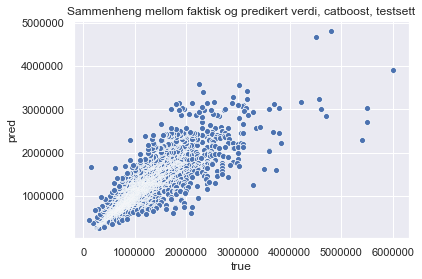

In [69]:
sns.scatterplot("true", "pred", data=rfc_res);
plt.title("Sammenheng mellom faktisk og predikert verdi, catboost, testsett");

### Metrikker

In [70]:
rfc_metrics = get_metrics(rfc_y_test, rfc_pred)

WALE: 0.15297620927914704
RMSE: 273246.2276038744
MAE: 170359.6397466313
R2: 0.7419225694110954


# Forklaringer
For en maskinlæringsmodell som skal brukes til prediksjon av verdien til fritidsboliger, mener vi at det er viktig å vite hvorfor modellen kom fram til prediksjonen sin. 

En lineær modell, som for eksempel lineær regresjon er relativt enkel å forstå, da koeffisientene til input-featurene kan leses direkte ut ifra modellen. 

Mer komplekse modeller, som for eksempel catboost kan være vanskeligere å forklare. Man kan få ut det som kalles "feature-importance", som sier noe om hvilke features som har mest å si for prediksjonen. Hvis man derimot vil forklare ett eksempel (en rad), er det vanskeligere å få en god forklaring med slike modeller.

Heldigvis har det vært forsket mye på metoder for å kunne forklare prediksjonene til komplekse maskinlæringsmodeller
I denne seksjonen vil vi demonstrere to rammeverk for forklaring av maskinlæringsmodeller:
- SHapley Additive exPlanations (SHAP)
- Local Interpretable Model-agnostic Explanations (LIME)

## Forklaringer for lineær regresjon

## Forklaringer for sklearn random forest

### Treeinterpreter

In [71]:
rfs_pred, rfs_bias, rfs_contributions = ti.predict(rfs, rfs_X_test)

NameError: name 'ti' is not defined

In [ ]:
for i in range(len(rfs_X_test[:2])):
    print("Instance", i)
    print("Bias (trainset mean)", rfs_bias[i])
    print("Feature contributions:")
    for c, feature in sorted(zip(rfs_contributions[i], 
                                 rfs_X_test.columns), 
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print("-"*20 )

## Forklaringer av catboost

### Feature-importance

In [ ]:
fi = list(zip(rf.feature_names_, rf.feature_importances_))
fi.sort(key=lambda x: x[1])
name, feature_importance = zip(*fi)
plt.barh(name, feature_importance);
plt.title("Feature importance plot");

Som vi ser i plottet over, er Distance, Postcode og Rooms de tre viktigste featurene for prediksjonen modellen gjør

### LIME
LIME er et modell-agnostisk rammeverk. Det vil si at det ikke har noe å si hvilken maskinlæringsmodell man bruker.
Det LIME gjør, er at den lager en lokal lineær approksimasjon av et eksempel. Selv om den globale modellen kan være kompleks, vil den lokale forklaringen være lettere å approksimere.

Intuisjonen bak LIME vises i bildet under. Modellens desisjonsfunksjon er representert med den blå/rosa bakgrunnen, og er helt klart ikke-lineær. Det store røde krysset er eksemplet som vi ønsker å forklare. Vi sampler så eksempler i nærheten av eksemplet vi ønsker å forklare. Vi lærer så en lineær modell (striplet linje) som approksimerer modellen godt i nærheten av dette eksemplet.

![](https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/lime.png)

La oss prøve å forklare eksemplet der catboost-modellen predikerer nærmest faktisk salgspris

In [ ]:
rf_explainer = lime.lime_tabular.LimeTabularExplainer(rf_X_train.values, feature_names=rf_X_train.columns, class_names="Price", mode="regression")

In [ ]:
best_pred_index = rf_res.iloc[0].name
rf_best_exp = rf_explainer.explain_instance(rf_X_test.loc[best_pred_index], rf.predict)
rf_best_exp.show_in_notebook()

In [ ]:
rf_best_exp.as_pyplot_figure();

I figurene ovenfor ser vi en forklaring på hvorfor modellen predikerte slik den gjorde. Måten å tolke figurene er å se på stolpene som går enten til venstre eller høyre, som bidragene fra de individuelle featurene for å trekke prisen opp eller ned. nullpunktet er gjenomsnittet av prediksjoner

I eksemplet over ser vi at siden postcode <= 40 trekkes boligen ned ca. 300 000 i verdi sammenlignet med gjennomsnittprediksjonen.

Vi ser også at siden Type <= 0 trekkes boligen opp ca. 300 000 i verdi sammenlignet med gjennomsnittprediksjonen

### LIME submodular pick
Med LIME submodular pick forsøker vi å finne et representativt utvalg av eksempler som forklarer modellen globalt

In [ ]:
sp_obj = submodular_pick.SubmodularPick(rf_explainer, rf_X_test.values, rf.predict)
[exp.show_in_notebook() for exp in sp_obj.sp_explanations];

## Forklaringer med SHAP

In [ ]:
lr_explainer = shap.LinearExplainer(linreg, lr_X_train)

In [ ]:
lr_shap_values = lr_explainer.shap_values(lr_X_test)

In [ ]:
shap.summary_plot(lr_shap_values, lr_X_test, plot_type="bar")

In [ ]:
lr_shap_values.shape

In [ ]:
shap.force_plot(lr_explainer.expected_value, lr_shap_values[0,:], lr_X_test.iloc[0])

In [ ]:
explainer = shap.TreeExplainer(rf)

In [ ]:
shap_values = explainer.shap_values(rf_X_train)

In [ ]:
shap_values

In [ ]:
print(f"True value: {rf_pred[0]}")
shap.force_plot(explainer.expected_value, shap_values[15195,:], rf_X_test.loc[15195])


In [ ]:
shap.force_plot(explainer.expected_value, shap,)

In [ ]:
shap.dependence_plot("Rooms", shap_values, rf_X_train)

In [ ]:
shap.summary_plot(shap_values, rf_X_train)

In [ ]:
shap.summary_plot(shap_values, rf_X_train, plot_type="bar")